In [1]:
%matplotlib nbagg
import hyperspy.api as hys
import numpy as np
import tkinter.filedialog as tkf

In [2]:
# 1) prepare EELS data (low loss and core loss)
hl = hys.load(tkf.askopenfilename(), signal_type = "EELS")
ll = hys.load(tkf.askopenfilename(), signal_type = "EELS")
print(hl)
print(ll)

<EELSSpectrum, title: 200kV-200X-0102_1, dimensions: (|2048)>
<EELSSpectrum, title: 200kV-200X-0102, dimensions: (|2048)>


In [3]:
hlc = hl
llc = ll

In [ ]:
hl_2d = np.sum(hl.data, axis=2)
print(hl_2d.shape)

In [ ]:
hl_2d = hys.signals.Signal2D(hl_2d)
roi = hys.roi.RectangularROI(left=10, right=50, top=10, bottom=50)
hl_2d.plot()
hlc = roi.interactive(hl_2d, color="red")

In [ ]:
roi_pos = [int(roi.y), int(roi.y+roi.height), int(roi.x), int(roi.x+roi.width)]
print(roi_pos)

hlc = hys.signals.EELSSpectrum(hl.data[roi_pos[0]:roi_pos[1], roi_pos[2]:roi_pos[3], :])
hlc.metadata = hl.metadata
hlc.axes_manager = hl.axes_manager

print(roi_pos)
llc = hys.signals.EELSSpectrum(ll.data[roi_pos[0]:roi_pos[1], roi_pos[2]:roi_pos[3], :])
llc.metadata = ll.metadata
llc.axes_manager = ll.axes_manager

hlc.axes_manager[0].size = roi_pos[3] - roi_pos[2]
hlc.axes_manager[1].size = roi_pos[1] - roi_pos[0]
llc.axes_manager[0].size = roi_pos[3] - roi_pos[2]
llc.axes_manager[1].size = roi_pos[1] - roi_pos[0]

print(hlc)
print(llc)

In [4]:
# 2) ZLP align
llc.align_zero_loss_peak(subpixel=True, also_align=[hlc])


Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	-0.6
std:	0

min:	-0.6
Q1:	-0.6
median:	-0.6
Q3:	-0.6
max:	-0.6


<IPython.core.display.Javascript object>


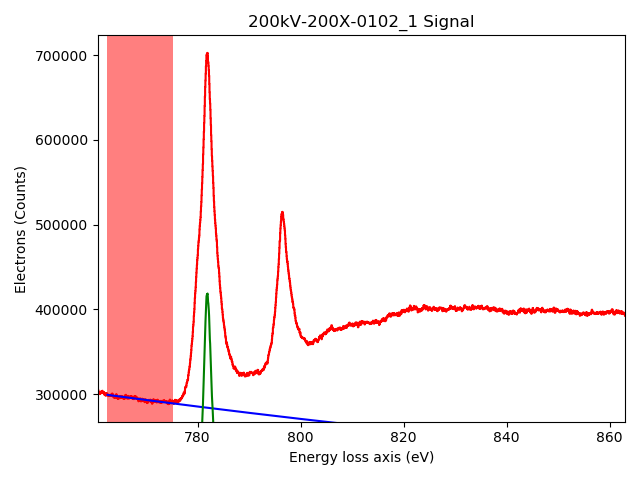

<IPython.core.display.Javascript object>


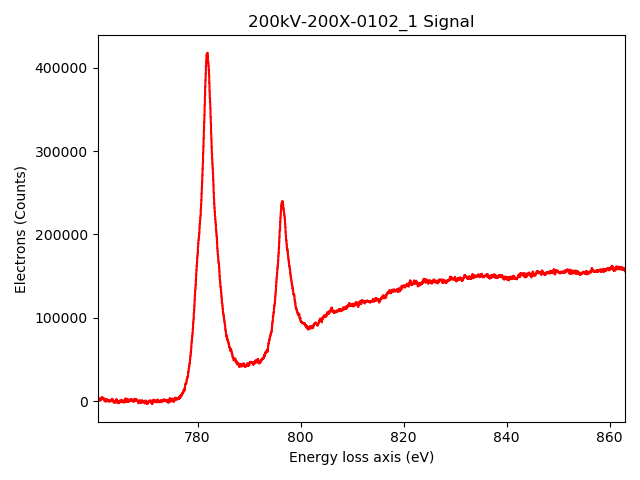

In [5]:
# 3) remove background
hlc.remove_background()

In [7]:
# 4) Fourier ratio deconvolution
hl_deconv = hlc.fourier_ratio_deconvolution(llc)

In [ ]:
hl_deconv.plot()

In [ ]:
hl_deconv.metadata

In [8]:
# 5) add elements
hl_deconv.add_elements(("Co",))

In [9]:
# 6) create a fitting model
model = hl_deconv.create_model(ll=llc, auto_background=False)
print(model.components)

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |               Co_L3 |               Co_L3 |          EELSCLEdge
   1 |               Co_L2 |               Co_L2 |          EELSCLEdge


In [13]:
# 7) fit the model
model.multifit(kind="smart")

<IPython.core.display.Javascript object>


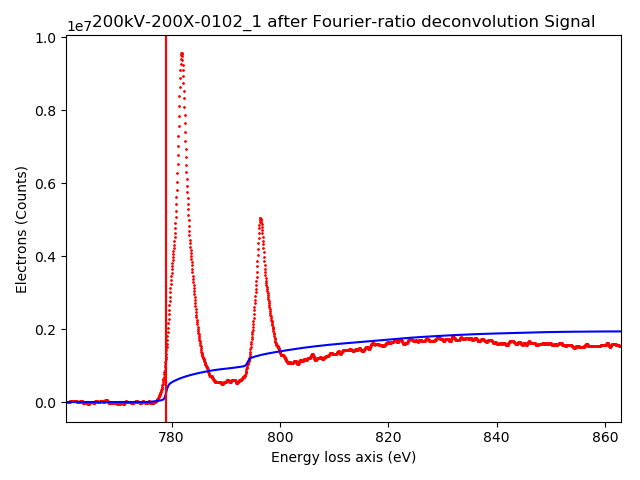

In [14]:
model.plot()
model.enable_adjust_position()

In [15]:
print(model.components.Co_L3.onset_energy.value)
print(model.components.Co_L2.onset_energy.value)

779.0
794.0


In [16]:
model.enable_fine_structure()
model.multifit(kind="smart")

<IPython.core.display.Javascript object>


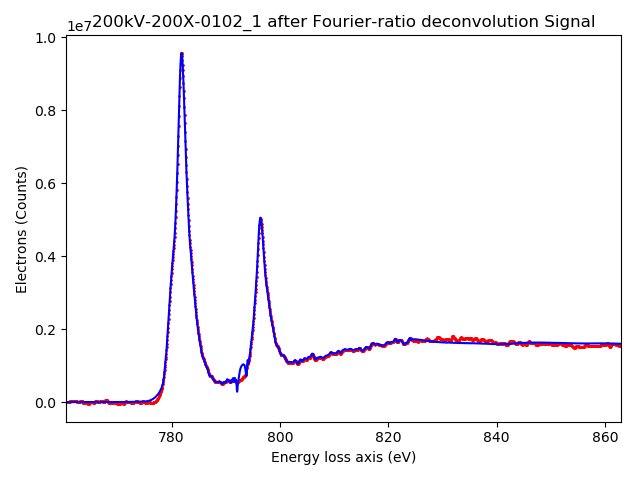

In [17]:
model.plot()

In [18]:
model.components.Co_L3.intensity.bmin = 0.0
model.multifit(fitter="leastsq", kind="smart", bounded=True)

<IPython.core.display.Javascript object>


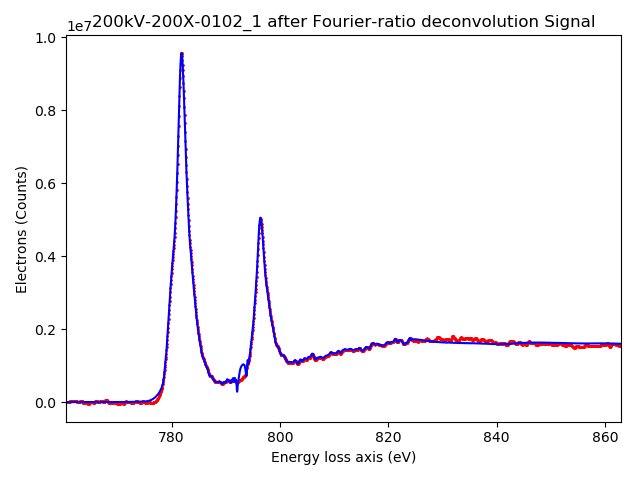

In [19]:
model.plot()

<IPython.core.display.Javascript object>


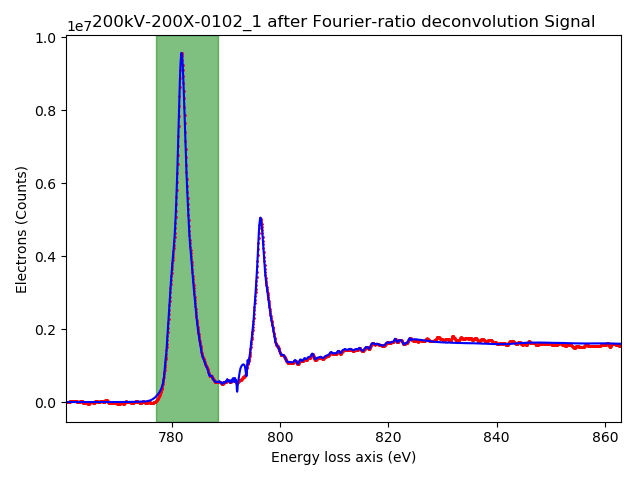

In [20]:
roi = hys.roi.SpanROI(left=750, right=800)
model.plot()
roi.add_widget(model, axes=["Energy loss"])

In [21]:
co_l3 = model.as_signal().isig[roi].integrate1D(axis="Energy loss")
print(co_l3.data)

[6.7209077e+08]


<IPython.core.display.Javascript object>


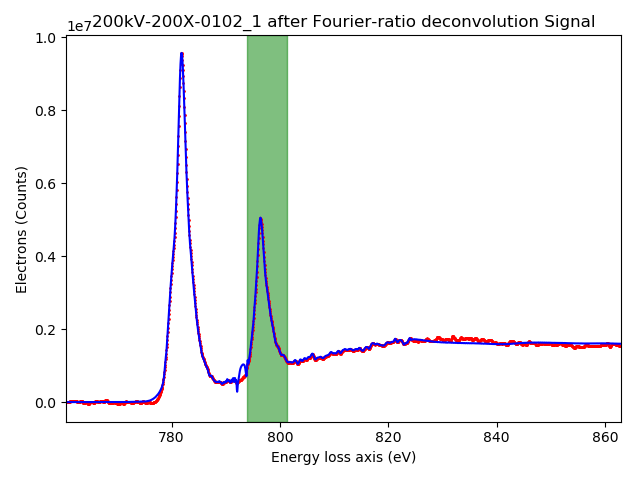

In [22]:
roi = hys.roi.SpanROI(left=750, right=800)
model.plot()
roi.add_widget(model, axes=["Energy loss"])

In [23]:
co_l2 = model.as_signal().isig[roi].integrate1D(axis="Energy loss")
print(co_l2.data)

[3.60052144e+08]


In [24]:
wl_ratio = co_l3 / co_l2
print(wl_ratio.data)

[1.86664843]
